In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
out_path = "../out/bert_student_augmented/m5_k10"

image_save_path = os.path.join('.', 'plots'); os.makedirs(image_save_path, exist_ok=True)

results_dict = {}

shen_loss_weights = ['0.5', '1', '2']
learning_rates = ['0.0002', '0.00002', '0.000002']
epochs_list = ['2', '3', '4']

for shen_loss_weight in shen_loss_weights:
    if shen_loss_weight not in results_dict:
        results_dict[shen_loss_weight] = {}
    for learning_rate in learning_rates:
        if learning_rate not in results_dict[shen_loss_weight]:
            results_dict[shen_loss_weight][learning_rate] = {}
        for epochs in epochs_list:
            version_identifier = f"shen_{shen_loss_weight}_lr{learning_rate}_e{epochs}_augmented"
            results_path = os.path.join(out_path, version_identifier, "results/results.json")
            try:
                with open(results_path, 'r') as file:
                    results = json.load(file)
                    if epochs not in results_dict[shen_loss_weight][learning_rate]:
                        results_dict[shen_loss_weight][learning_rate][epochs] = {}
                    results_dict[shen_loss_weight][learning_rate][epochs] = results
            except FileNotFoundError:
                print(f"Results file not found for version: {version_identifier}")
            except json.JSONDecodeError:
                print(f"Error decoding JSON for version: {version_identifier}")


In [3]:
results_dict['0.5']['0.0002']['2'].keys()

dict_keys(['y_true', 'y_pred', 'y_prob', 'predictive_variance', 'average_inference_time', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'auc_score', 'nll_score', 'brier_score', 'ece_score', 'bald_score'])

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "serif"

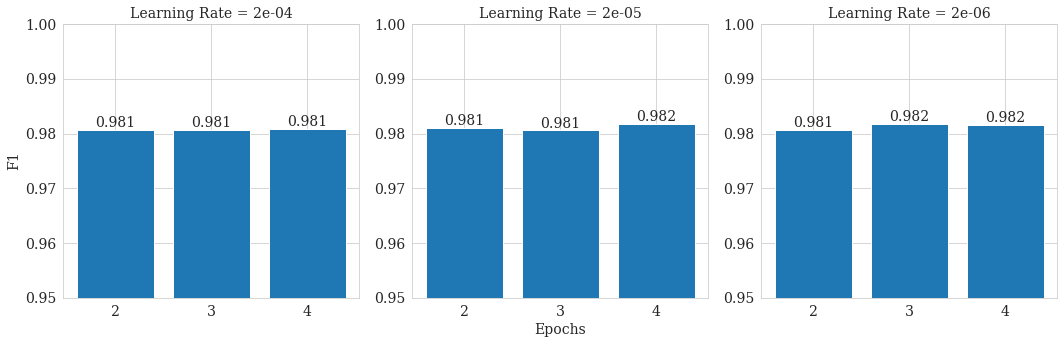

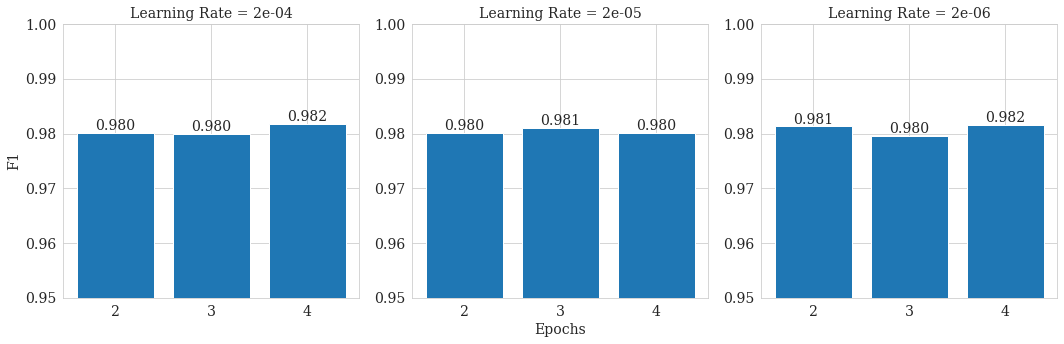

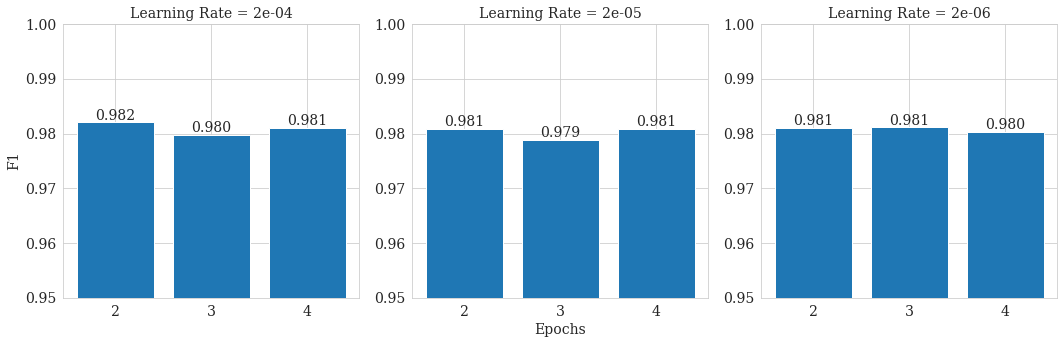

In [5]:
# per shen loss weight, plot learning rate vs epochs vs auc
# can then plot the three graphs in column type sub figs in latex with name being the lambda value
for shen_loss_weight in shen_loss_weights:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # fig.suptitle(f"$\lambda$ = {shen_loss_weight}")
    
    for i, learning_rate in enumerate(learning_rates):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for epochs in epochs_list]
        axs[i].bar(epochs_list, f1_values)
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.3f}", ha='center', va='bottom')
        learning_rate_float = float(learning_rate)
        # Format learning rate in scientific notation for the title
        formatted_learning_rate = f"{learning_rate_float:.0e}"
        axs[i].set_title(f"Learning Rate = {formatted_learning_rate}")
        if i == 1:
            axs[i].set_xlabel("Epochs")
        if i == 0:
            axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
    plt.tight_layout()
    # plt.savefig(os.path.join(image_save_path, f"plot_shen_loss_weight_{shen_loss_weight}.pdf"))
    # plt.close(fig)

- loss weight of $\lambda$ = 1 seems to perform best, on average, confirms findings of shen 2021

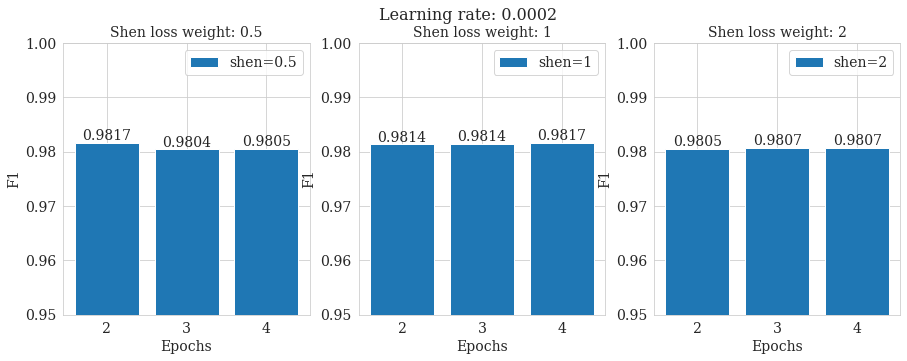

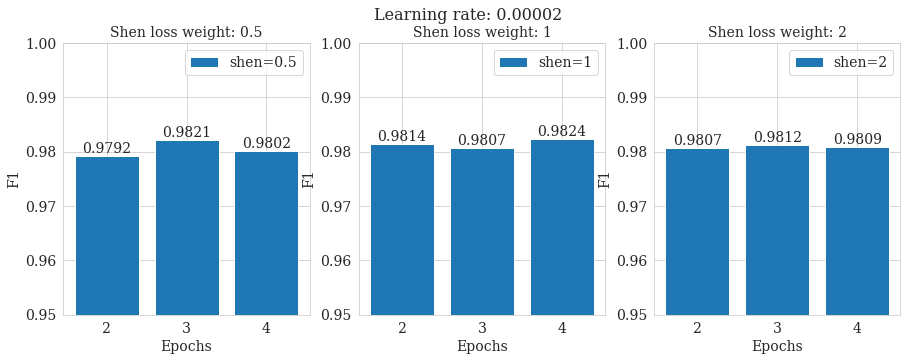

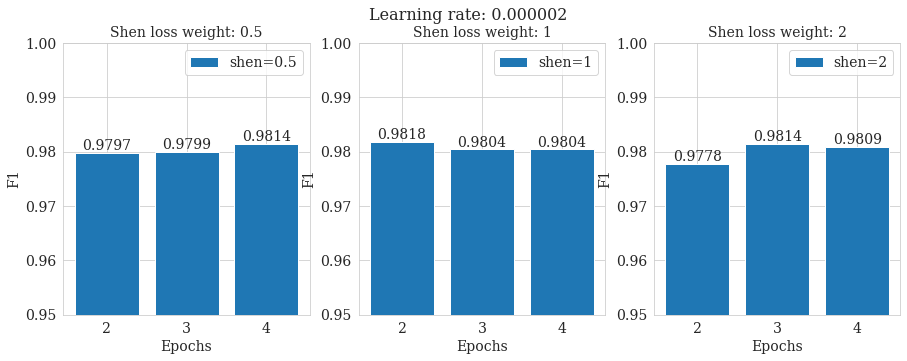

In [6]:
# per learning rate, plot shen loss weight vs epochs vs auc
for learning_rate in learning_rates:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Learning rate: {learning_rate}")
    for i, shen_loss_weight in enumerate(shen_loss_weights):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for epochs in epochs_list]
        axs[i].bar(epochs_list, f1_values, label=f"shen={shen_loss_weight}")
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.4f}", ha='center', va='bottom')
        axs[i].set_title(f"Shen loss weight: {shen_loss_weight}")
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
        axs[i].legend()
    plt.show()

- optimal student performance seems to be achieved with $\lambda$ = 1, learning rate of 0.00002, and 4 epochs

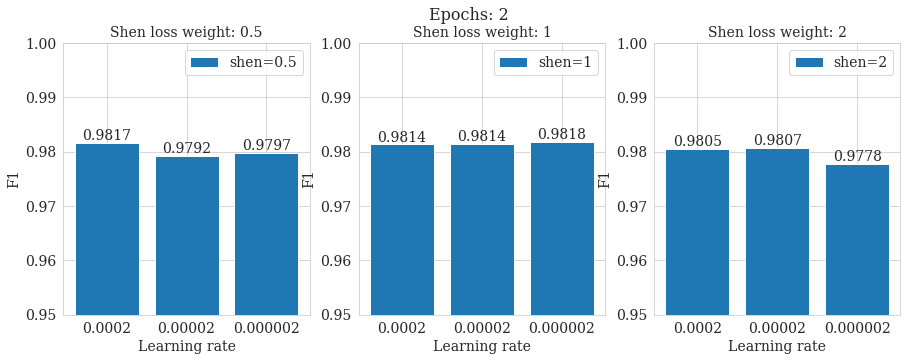

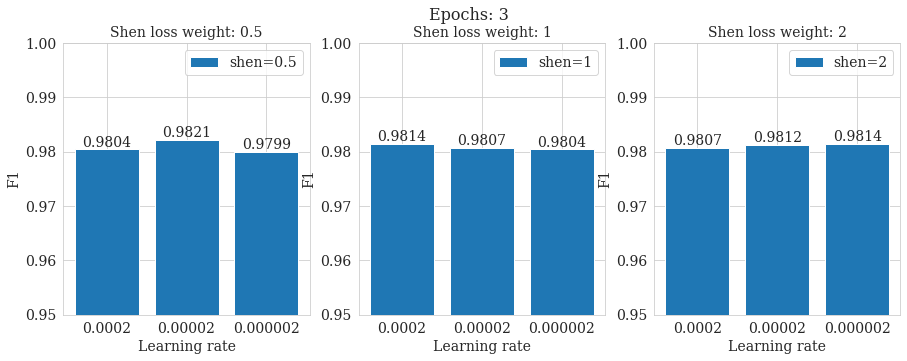

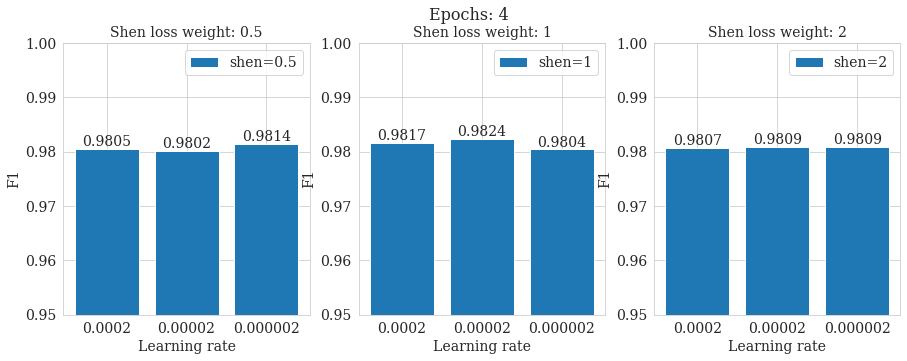

In [7]:
# per epochs, plot shen loss weight vs learning rate vs auc
for epochs in epochs_list:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Epochs: {epochs}")
    for i, shen_loss_weight in enumerate(shen_loss_weights):
        f1_values = [results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] for learning_rate in learning_rates]
        axs[i].bar(learning_rates, f1_values, label=f"shen={shen_loss_weight}")
        # add actual values on top of bars
        for j, f1 in enumerate(f1_values):
            axs[i].text(j, f1, f"{f1:.4f}", ha='center', va='bottom')
        axs[i].set_title(f"Shen loss weight: {shen_loss_weight}")
        axs[i].set_xlabel("Learning rate")
        axs[i].set_ylabel("F1")
        axs[i].set_ylim([0.95, 1])
        axs[i].legend()
    plt.show()

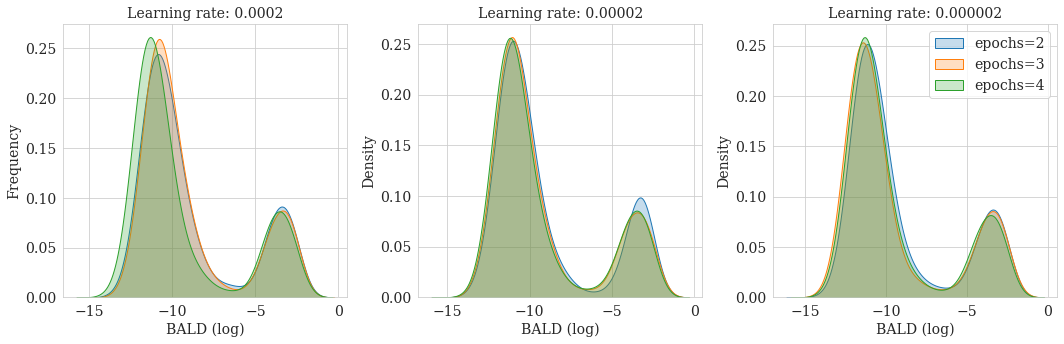

In [6]:
# for shen loss weight = 1, analyze bald score distribution per learning rate and epochs
shen_loss_weight = '1'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot layered bald kde plots for each learning rate
for i, learning_rate in enumerate(learning_rates):
    bald_scores = [np.log(results_dict[shen_loss_weight][learning_rate][epochs]['bald_score']) for epochs in epochs_list]
    for j, bald_score in enumerate(bald_scores):
        # axs[i].hist(bald_score, bins=20, alpha=0.5, label=f"epochs={epochs_list[j]}")
        # density plot
        sns.kdeplot(bald_score, ax=axs[i], label=f"epochs={epochs_list[j]}", fill=True)
    axs[i].set_title(f"Learning rate: {learning_rate}")
    axs[i].set_xlabel("BALD (log)")
    if i == 0:
        axs[i].set_ylabel("Frequency")
    # single legend for all subplots to the right of the last subplot
    if i == 2:
        axs[i].legend()
plt.tight_layout()

In [7]:
results_dict['1']['0.0002']['2']['ece_score']

0.3505544564379647

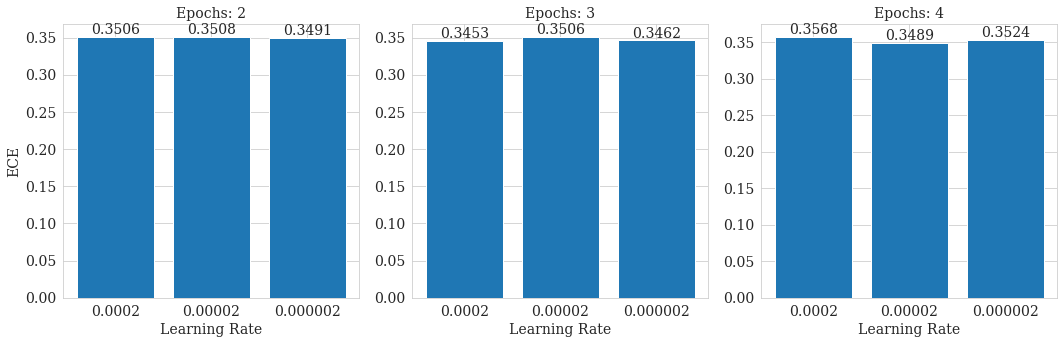

In [8]:
# for shen loss weight = 1, plot ECE per learning rate and epochs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# bar plot for each epoch
for i, epoch in enumerate(epochs_list):
    ece_values = [results_dict['1'][learning_rate][epoch]['ece_score'] for learning_rate in learning_rates]
    axs[i].bar(learning_rates, ece_values)
    # add actual values on top of bars
    for j, ece in enumerate(ece_values):
        axs[i].text(j, ece, f"{ece:.4f}", ha='center', va='bottom')
    axs[i].set_title(f"Epochs: {epoch}")
    axs[i].set_xlabel("Learning Rate")
    if i == 0:
        axs[i].set_ylabel("ECE")
    # axs[i].set_ylim([0, 0.16])
plt.tight_layout()

In [9]:
results_dict['2']['0.000002']['4']['auc_score'], results_dict['2']['0.000002']['4']['f1_score'], results_dict['2']['0.000002']['4']['ece_score']

(0.9908222791311083, 0.9802775748721695, 0.354493447917293)

In [10]:
results_dict['2']['0.00002']['2']['auc_score'], results_dict['2']['0.00002']['2']['f1_score'], results_dict['2']['0.00002']['2']['ece_score']


(0.9901122748745717, 0.9807832644125518, 0.34604546582953677)

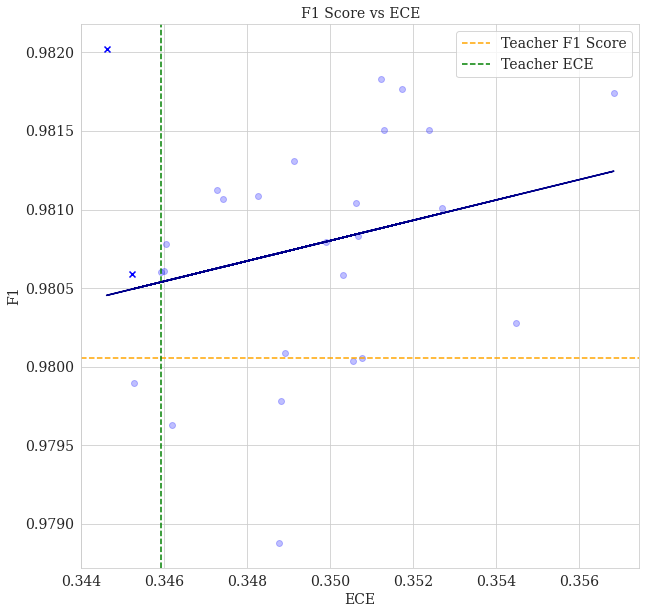

In [11]:
# plot f1 vs ECE and label with shen loss weight, learning rate and epochs
fig, ax = plt.subplots(figsize=(10, 10))

# add teacher f1 and ece as dashed lines
teacher_f1 = 0.9800554989854998
teacher_ece = 0.3459129210646457
ax.axhline(y=teacher_f1, color='orange', linestyle='--', label='Teacher F1 Score')
ax.axvline(x=teacher_ece, color='green', linestyle='--', label='Teacher ECE')

all_ece = []
all_f1 = []
for shen_loss_weight in shen_loss_weights:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            all_ece.append(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'])
            all_f1.append(results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'])
            
            # if f1 and ece both better than teacher, plot in dark blue, else light blue
            if results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] > teacher_f1 and results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'] < teacher_ece:
                ax.scatter(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'], results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'], color='blue', marker='x')
            else:
                ax.scatter(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'], results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'], color='blue', alpha=0.25)
            
            
            # ax.scatter(all_ece[-1], all_f1[-1])  #, label=f"shen={shen_loss_weight}, lr={learning_rate}, e={epochs}")

# Convert lists to arrays for numpy operations
all_ece = np.array(all_ece)
all_f1 = np.array(all_f1)

# Calculate linear regression
m, b = np.polyfit(all_ece, all_f1, 1)

# Calculate predictions for the trend line
predicted_f1 = m * all_ece + b

# Plot the trend line
ax.plot(all_ece, predicted_f1, color='darkblue')  #, label='Linear Trend')

ax.set_xlabel("ECE")
ax.set_ylabel("F1")
ax.set_title("F1 Score vs ECE")
ax.legend(); 

(There appears to be some kind of trade off between uncertainty performance (ECE) and classification performance (F1)). The best performing models in terms of F1 score have relatively high ECE scores (above teacher ECE). The best performing models in terms of ECE score have F1 scores above 0.98 (and still above teacher performance), confirming that uncertainty distillation achieves in distilling a student that outperforms its teacher both in terms of predictive performance and uncertainty calibration.

In [12]:
# find combination with ECE below 0.345 and f1 above 0.98
for shen_loss_weight in shen_loss_weights:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            f1 = results_dict[shen_loss_weight][learning_rate][epochs]['f1_score']
            ece = results_dict[shen_loss_weight][learning_rate][epochs]['ece_score']
            auc = results_dict[shen_loss_weight][learning_rate][epochs]['auc_score']
            if ece < 0.345 and f1 > 0.98:
                print(f"shen={shen_loss_weight}, lr={learning_rate}, e={epochs}, f1={f1}, ece={ece}, auc={auc}")
                

shen=2, lr=0.0002, e=2, f1=0.9820213799805636, ece=0.34460585905099667, auc=0.9916276484147309
